In [3]:
%matplotlib inline

import copy
import pandas as pd
import numpy as np
import pylab as pl

from matplotlib.pyplot import cm
from nltk import word_tokenize
from collections import Counter

from nltk.collocations import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.stem.snowball import SnowballStemmer

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

morph_en = SnowballStemmer("english")

### Получение текстов ###
Получим из изначальных данных тексты. Есть 2 доступных поля: RawText и ExtractedBodyText. Я взял ExtractedBodyText, потому что в первом поле хранится вся история переписки, мне не очень хотелось иметь дело с дубликатами. К тому же, второе поле вполне приемлемо очищено.

Сразу же удалим строчки с оставшейся служебной информацией.

In [43]:
def get_texts():
    emails = pd.read_csv("data/Emails.csv")
    persons = pd.read_csv("data/Persons.csv")

    emails.rename(columns={"Id": "EmailId"}, inplace=True)
    data = emails[['EmailId', "ExtractedBodyText", "SenderPersonId"]]

    data = pd.merge(data, persons, left_on=["SenderPersonId"], right_on="Id")
    data.rename(columns={"Name": "SenderPersonName"}, inplace=True)
    data.drop(["Id"], axis=1, inplace=True)

    data = data[data.ExtractedBodyText.notnull()]

    texts = data.ExtractedBodyText.tolist()

    bad_lines = ["U.S. Departm", "ent of State", "STATE-", "Case No.", "Doc No.", "Date:", "STATE DEPT", "SUBJECT TO", "B5",
                 "B6", "1.4", "(D)", "(B)", "(E)", "B1", "B2", "B3", "B4", "Prom", "To:", "---", "Attachment=", "Subject:", "Sent:",
                 "For:", "RELEASE IN", "@", "©", "Re:", "FW:", "Cc:", "From", "RE:", "CC:", "Fw:", "Your message was delivered",
                 "UNCLASSIF", "ED", ", January", ", February ", ", March ", ", April ", ", May ", ", June ",
                 ", July ", ", August ", ", September ", ", October ", ", November", ", December ", "--", "— —", "—", "###",
                 "http", "Sent from", "Sent via"]
    for i in range(len(texts)):
        good_lines = []
        for line in texts[i].split("\n"):
            is_bad_line = False
            for bad_line in bad_lines:
                if bad_line in line:
                    is_bad_line = True
            if not is_bad_line:
                good_lines.append(line)
        texts[i] = "\n".join(good_lines)
    return texts

texts = get_texts()
print(len(texts))
print("\n---\n".join(texts[50:55]))

6721
Definitely. I can share around if you like, but it seems like a thin conspiracy theory.
This one strains credulity. What do you think?
---
FYI
---
Can I call you in 30? Several items.
---
Secretary Clinton's leadership on Libya
as the public face of the U.S. effort in Libya. She was instrumental in securing the authorization, building the coalition,
and tightening the noose around Qadhafi and his regime.
embassy.
sanctions on Gaddafi and his family and refers Qadhafi and his cronies to the ICC
address in which she says: "Colonel Qadhafi and those around him must be held accountable for these acts, which
violate international legal obligations and common decency. Through their actions, they have lost the legitimacy to
govern. And the people of Libya have made themselves
Libya from membership in the Human Rights Council.
representative to Benghazi
She meets with INC representative Jibril and consults with her colleagues on further UN Security Council action. She
notes that a no-fly 

### Токенизация ###
Используем nltk.word_tokenize, оставляем только буквенно-числовые токены и '. Уберём некоторые стопслова.

In [5]:
def tokenize(text, stopwords):
    tokens = word_tokenize(text)
    clean_tokens = [w.lower() for w in tokens if w.isalnum() or "'" in w]
    bad_tokens = ['h', "'1.com", "'.iyar", ".i't", "''"]
    return [token for token in clean_tokens if token not in bad_tokens and token not in stopwords]

def get_tokenized_texts(texts, stopwords):
    tokenized_texts = []
    for text in texts:
        clean_tokens = tokenize(text, stopwords)
        tokenized_texts.append(clean_tokens)
    return tokenized_texts

stopwords = ["the", "a", "an", "of", "to", "and", "for", "in", "'s", "on", "with", "as", "at", "from", "but"]
tokenized_texts = get_tokenized_texts(texts, stopwords)
print("\n---\n".join([" ".join(text) for text in tokenized_texts[50:55]]))

definitely i can share around if you like it seems like thin conspiracy theory this one strains credulity what do you think
---
fyi
---
can i call you 30 several items
---
secretary clinton leadership libya public face effort libya she was instrumental securing authorization building coalition tightening noose around qadhafi his regime embassy sanctions gaddafi his family refers qadhafi his cronies icc address which she says colonel qadhafi those around him must be held accountable these acts which violate international legal obligations common decency through their actions they have lost legitimacy govern people libya have made themselves libya membership human rights council representative benghazi she meets inc representative jibril consults her colleagues further un security council action she notes that zone will not be adequate she is leading voice strong unsc action nato civilian protection mission 1973 authorizes zone over libya all necessary measures code military action prote

### Статистика по биграммам и collocations ###
Топ-10 биграмм выгляит неплохо.

На первый взгляд, может показаться, что в collocations какая-то ерунда. На самом деле, это: "81701 vat" - размер налога, "e98 1xy" - район Лондона, "Har Homa" - поселение в Израиле, "Jassim Jabr" - премьер-министр Катара, "lame duck" - неформальное прозвище президента с определёнными свойствами, "PhD Purdue" - указание на степень, полученную в университете Пердью, "SVC 217" - комната в Белом доме (но это не точно), "SW1H OBL" - указание на адрес в Лондоне, "Ashfaq Parvez" - пакистанский генерал.

In [24]:
def count_ngrams_freq(tokenized_texts, n):
    ngrams = Counter()
    for text in tokenized_texts:
        for i in range(len(text)-n+1):
            ngram = " ".join(text[i:i+n])
            ngrams[ngram] += 1
    return ngrams


def count_bigrams_mi(tokenized_texts):
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words([token for text in tokenized_texts for token in text+['EOF']])
    finder.apply_freq_filter(3)
    return finder.nbest(bigram_measures.pmi, 10)

print(count_ngrams_freq(tokenized_texts, 2).most_common(10))
print(count_bigrams_mi(tokenized_texts))

[('it is', 534), ('will be', 512), ('secretary office', 458), ('state department', 443), ('united states', 427), ('white house', 396), ("i 'm", 393), ("do n't", 368), ('this is', 361), ('has been', 357)]
[('81701', 'vat'), ('e98', '1xy'), ('har', 'homa'), ('hong', 'kong'), ('jassim', 'jabr'), ('lame', 'duck'), ('phd', 'purdue'), ('svc', '217'), ('sw1h', 'obl'), ('ashfaq', 'parvez')]


### Выделяем признаки ###
Знакомая функция, используем TfIdf и стемминг.

In [7]:
def stem_sentence(sentence):
    words = sentence.split(" ")
    for j in range(len(words)):
        words[j] = morph_en.stem(words[j])
    return " ".join(words)

def bow(train_texts, test_texts, stem=False, tokenizer=None, preprocessor=None,
        use_tfidf=False, max_features=None, bow_ngrams=(1, 2), analyzer='word'):
    train = copy.deepcopy(train_texts)
    test = copy.deepcopy(test_texts)
    if stem:
        for i in range(len(train)):
            train[i] = stem_sentence(train[i])
        for i in range(len(test)):
            test[i] = stem_sentence(test[i])

    if use_tfidf:
        vectorizer = TfidfVectorizer(analyzer=analyzer, ngram_range=bow_ngrams, tokenizer=tokenizer,
                                     preprocessor=preprocessor, max_features=max_features)
    else:
        vectorizer = CountVectorizer(analyzer=analyzer, ngram_range=bow_ngrams, tokenizer=tokenizer,
                                     preprocessor=preprocessor, max_features=max_features)
    data = train+test
    data = vectorizer.fit_transform(data)
    train_data = data[:len(train)]
    test_data = data[len(train):]
    return train_data, test_data

train_texts = [" ".join(text) for text in tokenized_texts]
X = bow(train_texts, [], use_tfidf=True, stem=True, bow_ngrams=(1,2))[0]
print(X.shape)

(6721, 244438)


### Кластеризация ###
Ура! Наконец-то кластеризация. Всё просто, используем k-means, количество кластеров я долго и мучительно подбирал. Зря. Почему - расскажу ниже.

Для хоть какого-то представления о том, что происходит, уменьшаем размерность пространства признаков до 3 и рисуем 3 проекции, кластеры раскрашиваем.

Для каждого кластера выводим - самые частотные слова, самые частотные биграммы и коллокации (на всякий случай).

In [34]:
def clustering(X, n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=5, verbose=False, random_state=42)
    km.fit(X)
    y = km.labels_.tolist()
    return y

n_clusters = 9
y = clustering(X, n_clusters)
print(y[:100])

[0, 0, 0, 2, 2, 2, 4, 0, 0, 0, 2, 4, 3, 2, 2, 0, 6, 4, 2, 6, 2, 6, 0, 2, 3, 5, 2, 2, 6, 4, 3, 2, 2, 6, 6, 4, 2, 4, 0, 2, 2, 3, 0, 6, 6, 4, 0, 2, 2, 2, 6, 0, 1, 3, 0, 3, 0, 2, 0, 2, 2, 2, 6, 6, 2, 2, 5, 2, 6, 2, 2, 2, 6, 2, 6, 6, 6, 6, 6, 6, 2, 6, 2, 3, 2, 6, 6, 2, 2, 6, 2, 3, 2, 2, 2, 6, 2, 2, 2, 2]


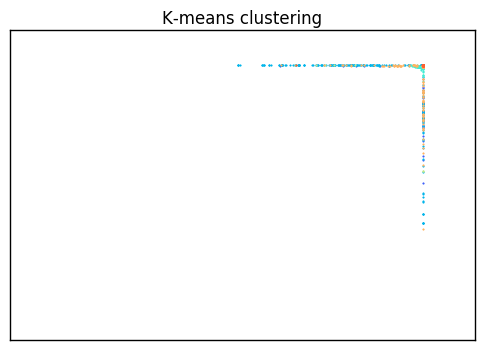

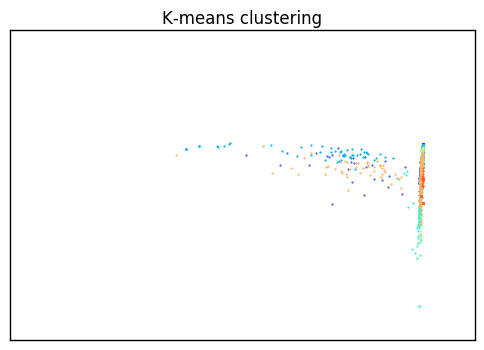

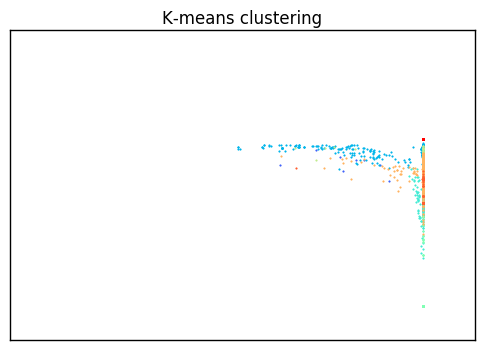

In [35]:
def reduce_dimensionality(X):
    svd = TruncatedSVD(3)
    return svd.fit_transform(X)


def plot2D(X, y, i, j, n_clusters):
    x_min, x_max = X[:, i].min() + 0.8, X[:, i].max() - 1.1
    y_min, y_max = X[:, j].min() + 0.8, X[:, j].max() - 1.1
    pl.figure(1)
    pl.clf()

    color = iter(cm.rainbow(np.linspace(0, 1, n_clusters)))
    df = pd.DataFrame(dict(x=X[:, i], y=X[:, j], label=y))
    groups = df.groupby('label')
    for label, group in groups:
        pl.plot(group.x, group.y, 'k.', markersize=2, color=next(color))

    pl.title('K-means clustering')
    pl.xlim(x_min, x_max)
    pl.ylim(y_min, y_max)
    pl.xticks(())
    pl.yticks(())
    pl.show()

reduced = reduce_dimensionality(X)
plot2D(reduced, y, 0, 1, n_clusters)
plot2D(reduced, y, 1, 2, n_clusters)
plot2D(reduced, y, 0, 2, n_clusters)

In [22]:
clusters = [[] for i in range(n_clusters)]
for i in range(len(y)):
    clusters[y[i]].append(tokenized_texts[i])

def describe_cluster(cluster):
    size = len(cluster)
    common_words = count_ngrams_freq(cluster, 1).most_common(10)
    common_bigrams = count_ngrams_freq(cluster, 2).most_common(10)
    mi = count_bigrams_mi(cluster)
    mean_len = sum([len(text) for text in cluster])/len(cluster)
    description = "Cluster of " + str(size) + " texts, with " + str(mean_len) + " average word length\n"
    common_words = ", ".join([pair[0] for pair in common_words])
    description += "Common words: " + str(common_words) + "\n"
    common_bigrams = ", ".join([pair[0] for pair in common_bigrams])
    description += "Common bigrams: " + str(common_bigrams) + "\n"
    mi = ", ".join([" ".join(pair) for pair in mi])
    description += "MI: " + str(mi)
    print(description)
    
for i in range(n_clusters):
    print("-----------------------------" + str(i) + " CLUSTER" + "-----------------------------")
    describe_cluster(clusters[i])

-----------------------------0 CLUSTER-----------------------------
Cluster of 492 texts, with 1.0020325203252032 average word length
Common words: fyi, c
Common bigrams: fyi c
MI: EOF fyi, fyi EOF
-----------------------------1 CLUSTER-----------------------------
Cluster of 541 texts, with 15.308687615526802 average word length
Common words: call, you, i, can, will, me, is, do, if, have
Common bigrams: can you, will call, call sheet, i 'm, call you, you call, if you, call me, i can, you can
MI: viktor bout, department operations, nita lowey, sporadic access, middle east, checking periodically, state department, chris hill, overseas only, traveling overseas
-----------------------------2 CLUSTER-----------------------------
Cluster of 3030 texts, with 12.594389438943894 average word length
Common words: i, is, you, will, that, this, it, have, see, 2
Common bigrams: i 'm, 1 1, i will, see below, 2 2, 2 1, will be, 2009 2009, i have, sullivan jacob
MI: cingular xpress, los angeles, debt

### Промежуточные итоги ###
Ну, очевидно, что получилось не очень. Какие кластеры чёткие: ok-кластер, print-кластер, "will do"-кластер, "fyi"-кластер (FYI-for your information). Ещё можно заметить кластеры звонков (call) и кластер мест (pm, am, office, residence), но они слишком большие, чтобы быть правдой. Все перечисленные выше кластеры "стабильны" и устойчивы к перезапускам, изменению random seed'а и минимальным изменениям набора стоп-слов. Очевидно, что  "выбросы" на проекциях - представители 4 чётких кластеров.

Так давайте избавимся от них, чтобы лучше выделить остальные кластеры! Избавляться будем очень просто: увеличим список стоп-слов и отрежем все тексты, в которых после токенизации меньше 4 токенов.

In [44]:
hard_stop = ["the", "a", "an", 
             "of", "to", "and", "for", "in", "'s", "on", "with", "as", "at", 
             "from", "but", "or", "just", "so", "by", "if", "about", "just", "also", "out", "up",
             "we", "i", "they", "you", "he", "she", "his", "her", "my", "it", "your", "me", "u", "our", "him", "w", "their", "its",
             "be", "is", "are", "will", "would", "have", "has", "was", "were", "am", "had", "can",
             "1", "2",
             "that", "this", "there", 
             "not", "n't",
             "do", "did",
             "yes", 
             "'ll", "'m", "'d",
             "who", "which", "what", "when",
             "below",
             "can"]

def get_tokenized_texts_hard(texts, stopwords):
    tokenized_texts = []
    for text in texts:
        clean_tokens = tokenize(text, stopwords)
        clean_tokens = [token for token in clean_tokens if len(token) >= 1]
        if len(clean_tokens) < 4:
            continue
        tokenized_texts.append(clean_tokens)
    return tokenized_texts
tokenized_texts_hard = get_tokenized_texts_hard(texts, hard_stop)
print(len(tokenized_texts_hard))
print("\n---\n".join([" ".join(text) for text in tokenized_texts_hard[50:55]]))

4092
attached latest version speech incorporating comments sandy strobe well edits cheryl lissa while improved grown length now bit shorter than senate confirmation testimony places cut want see full make own assessments revised text dennis going sharpen hone sections middle east iran ask holbrooke work piece available any time discuss 142
---
jake sullivan reines philippe special use only brazil mexico
---
jim raise greek ambassador yesterday told aware situation come back report jim got corfu
---
tom backgrounder definitely played down expectations
---
happy know jack been working weekend behalf good friends palau getting new numbers next round negotiations stay top though no matter don't think 100 percent satisfied


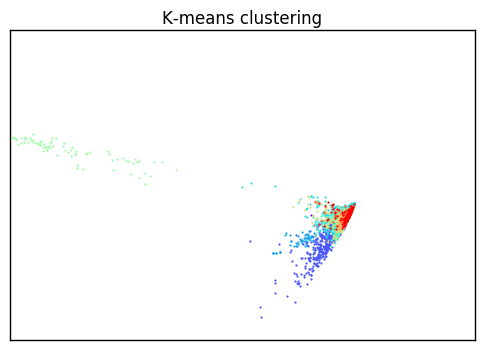

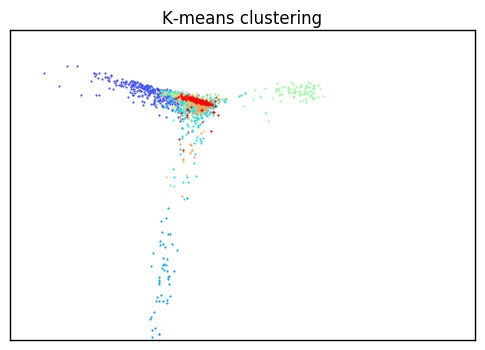

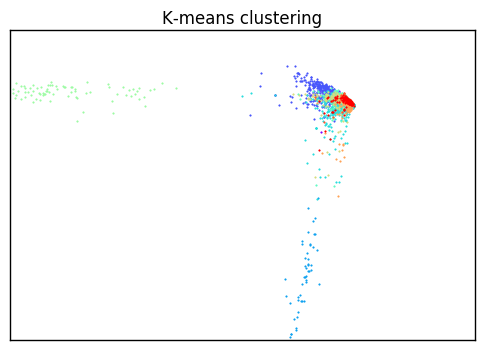

In [45]:
train_texts_hard = [" ".join(text) for text in tokenized_texts_hard]
X_hard = bow(train_texts_hard, [], use_tfidf=True, stem=True, bow_ngrams=(1,2))[0]
n_clusters = 10
y = clustering(X_hard, n_clusters)

reduced = reduce_dimensionality(X_hard)
plot2D(reduced, y, 0, 1, n_clusters)
plot2D(reduced, y, 1, 2, n_clusters)
plot2D(reduced, y, 0, 2, n_clusters)

clusters = [[] for i in range(n_clusters)]
for i in range(len(y)):
    clusters[y[i]].append(tokenized_texts_hard[i])

In [46]:
for i in range(n_clusters):
    print("-----------------------------" + str(i) + " CLUSTER" + "-----------------------------")
    describe_cluster(clusters[i])

-----------------------------0 CLUSTER-----------------------------
Cluster of 234 texts, with 20.021367521367523 average word length
Common words: know, let, want, all, get, time, good, any, see, work
Common bigrams: let know, let discuss, know any, know how, pls let, please let, know want, next week, let us, know time
MI: en route, financing terrorism, cheryl d, mills cheryl, middle east, foreign minister, mexican employee, cherie blair, team columbia, huma abedin
-----------------------------1 CLUSTER-----------------------------
Cluster of 375 texts, with 610.1333333333333 average word length
Common words: obama, said, more, president, one, been, new, all, people, us
Common bigrams: united states, white house, more than, new york, secretary state, health care, state department, foreign policy, prime minister, national security
MI: 243 8054, 81701 vat, buenos aires, e98 1xy, har homa, hong kong, phd purdue, pickup truck, abdul ghani, brent scowcroft
-----------------------------2 CL

### Новая надежда ###
Ну, во-первых, почему именно 10 кластеров? Тут я каюсь, опирался на проекции. И когда кластеры стали визуально отделимы при некоторых настройках, остановился. Выше - чуть-чуть другие настройки и имеено 9 кластеров не так очевидны.

Во-вторых, мы получили: кластер о просьбах сообщить о чём-то (know, let, want), правдоподобный кластер звонков (call), правдоподобный кластер встреч и мест (pm, office, meeting, depart, коллокация four seasons), просьбы о распечатке, звонке, рассказе (pls call, pls sure, add call, pls keep), обсуждение Обамы и его политики(obama, president, people, средняя длина ~ 600 слов), мусорный кластер с именами получателей (huma, abedin, sullivan), переписка с одной из секретарей (almoro, lona, state, secretary), кластер про планирование (tomorrow, morning, today, time), кластер с системными ошибками (original message, recipient address, system administrator) и все остальные письма.



Вообще можно продолжить "масштабировать", но как по мне для учебного задания этого вполне хватит.

### Асессмент ###
Я придумал 2 метода асессмента - один долгий и один быстрый.

Долгий - даём набор писем, даём набор названий кластеров (тот, который у нас получился) и просим отнести письмо к одному из них. Считаем точность и полноту по каждому кластеру. Вместе с интерпртируемостью сразу оценивается и точность кластеризации.

Быстрый - берём асессора, даём ему вывод описания кластеров, просим рассказать, как бы он это обозвал. Сравниваем с тем, как обозвали это мы.

Я сделал быстрый асессмент на человеке, очень далёком от анализа текстов. На примерно 3/4 кластеров наши "названия" концептуально совпали.